#### Task is to apply k-means to the iris dataset. What happens when you change value of k? What's the best solution. Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor. Keep in mind that it's possible you may find a solution with more than 3 clusters that nevertheless better tracks the real, trinary outcome – two of those clusters may map to a single flower type while the other two map to the other types for example

Load data and standardize

In [25]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Next, we fit k-means with k values equal to 2, 3, 4, 5 and 6:

In [3]:
# Defining the k-means

cluster_numbers = [2, 3, 4, 5, 6]
kmeans_clusters = []
for i in cluster_numbers:
    k_means = KMeans(n_clusters=i, random_state=123)
    kmeans_clusters.append(k_means.fit_predict(X_std))

Next, we visualize each k-means solution:

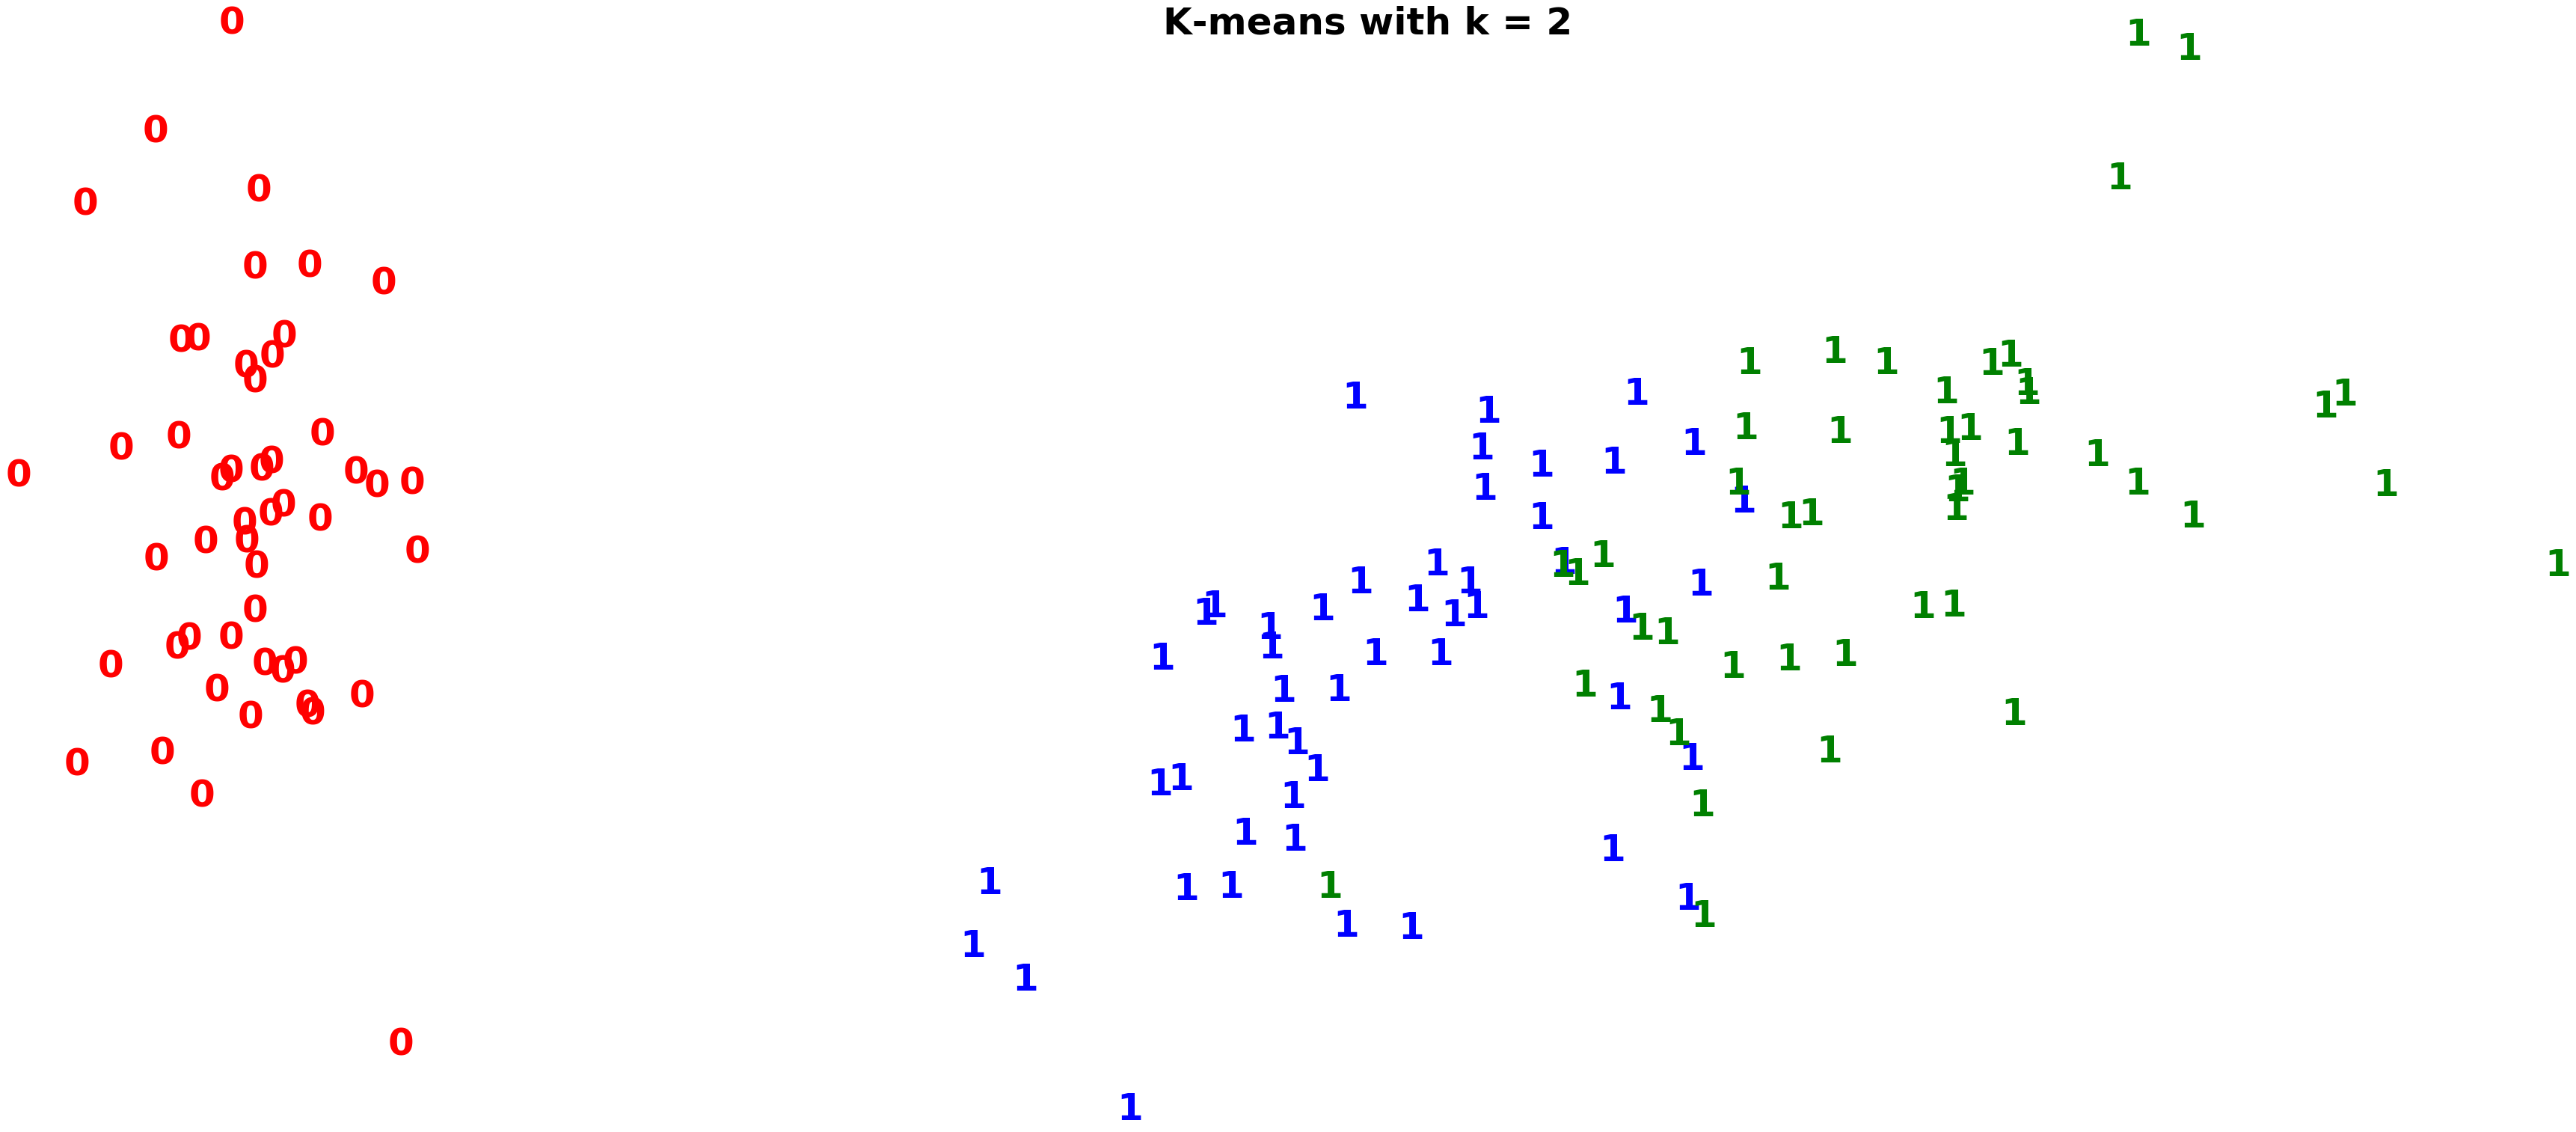

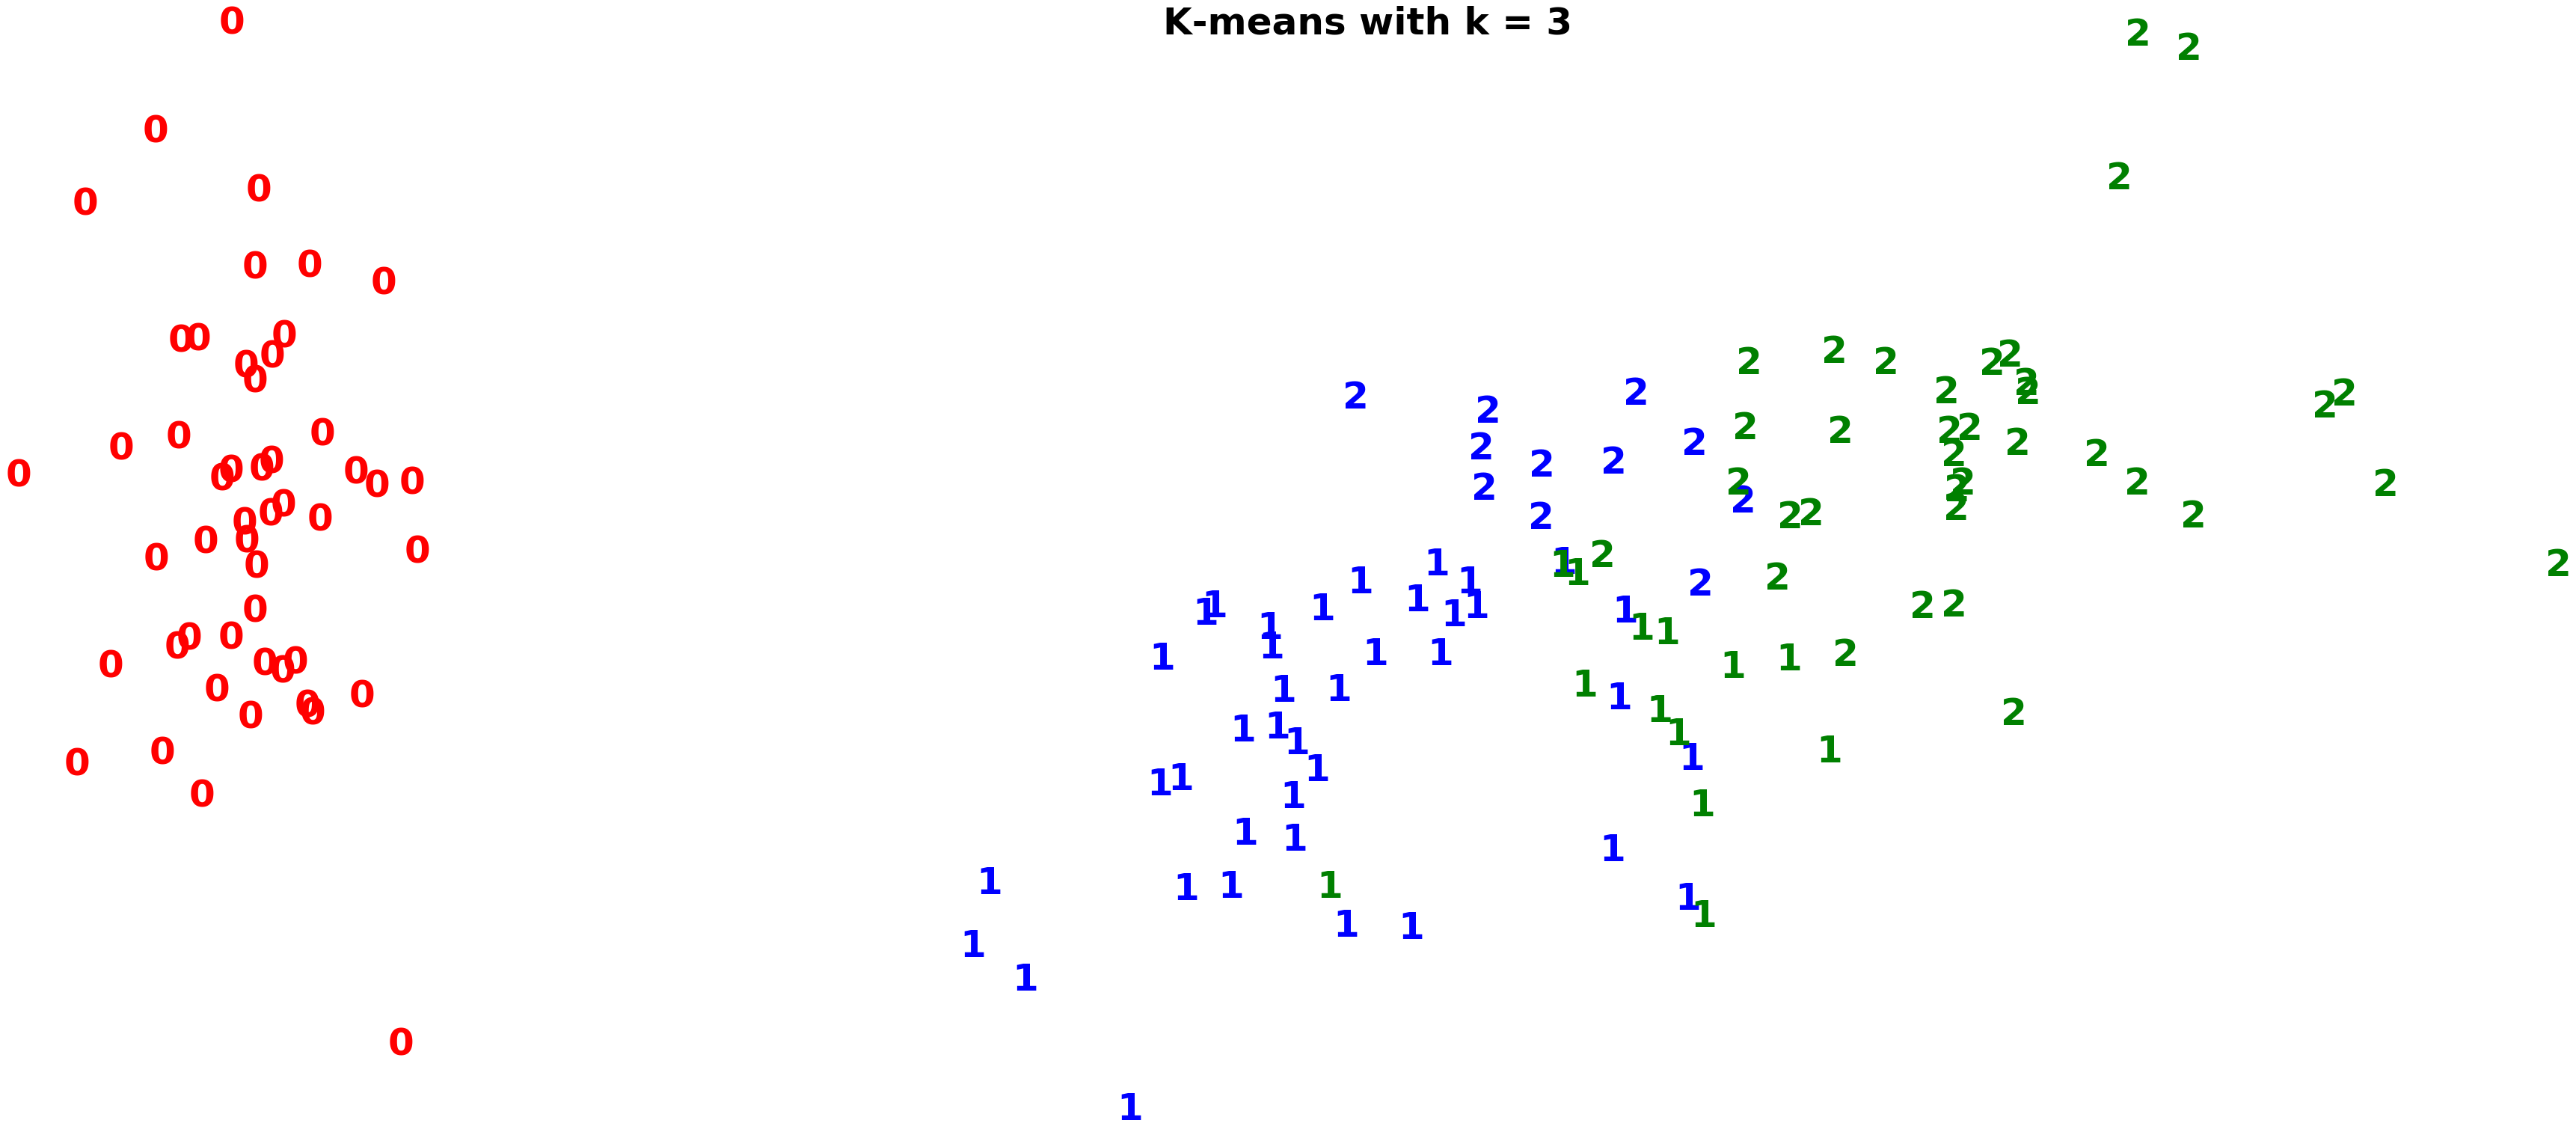

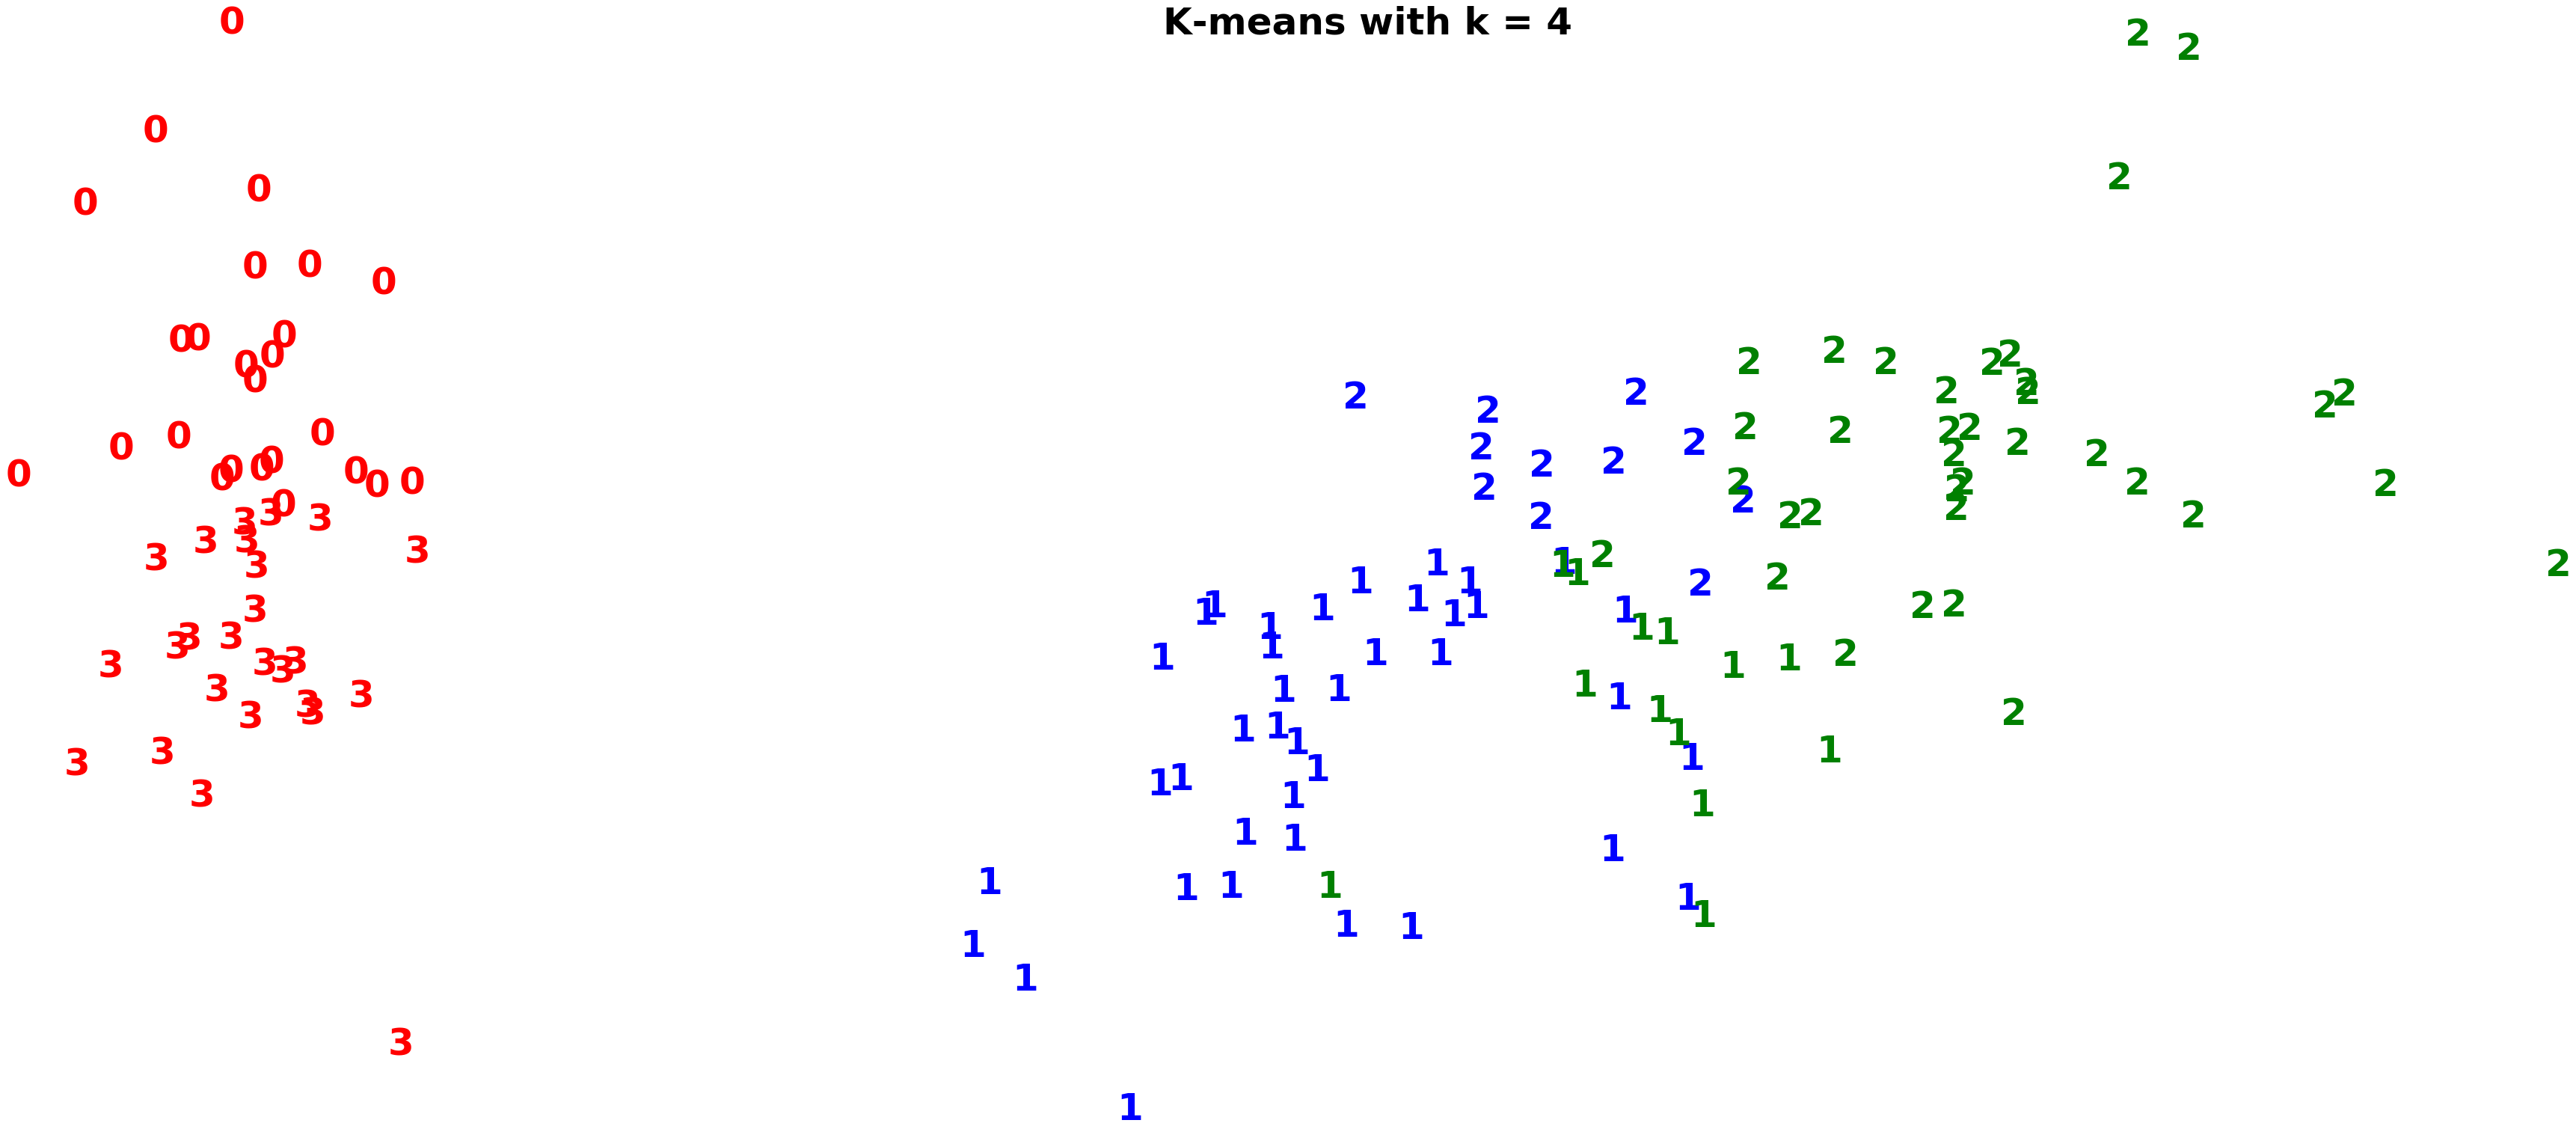

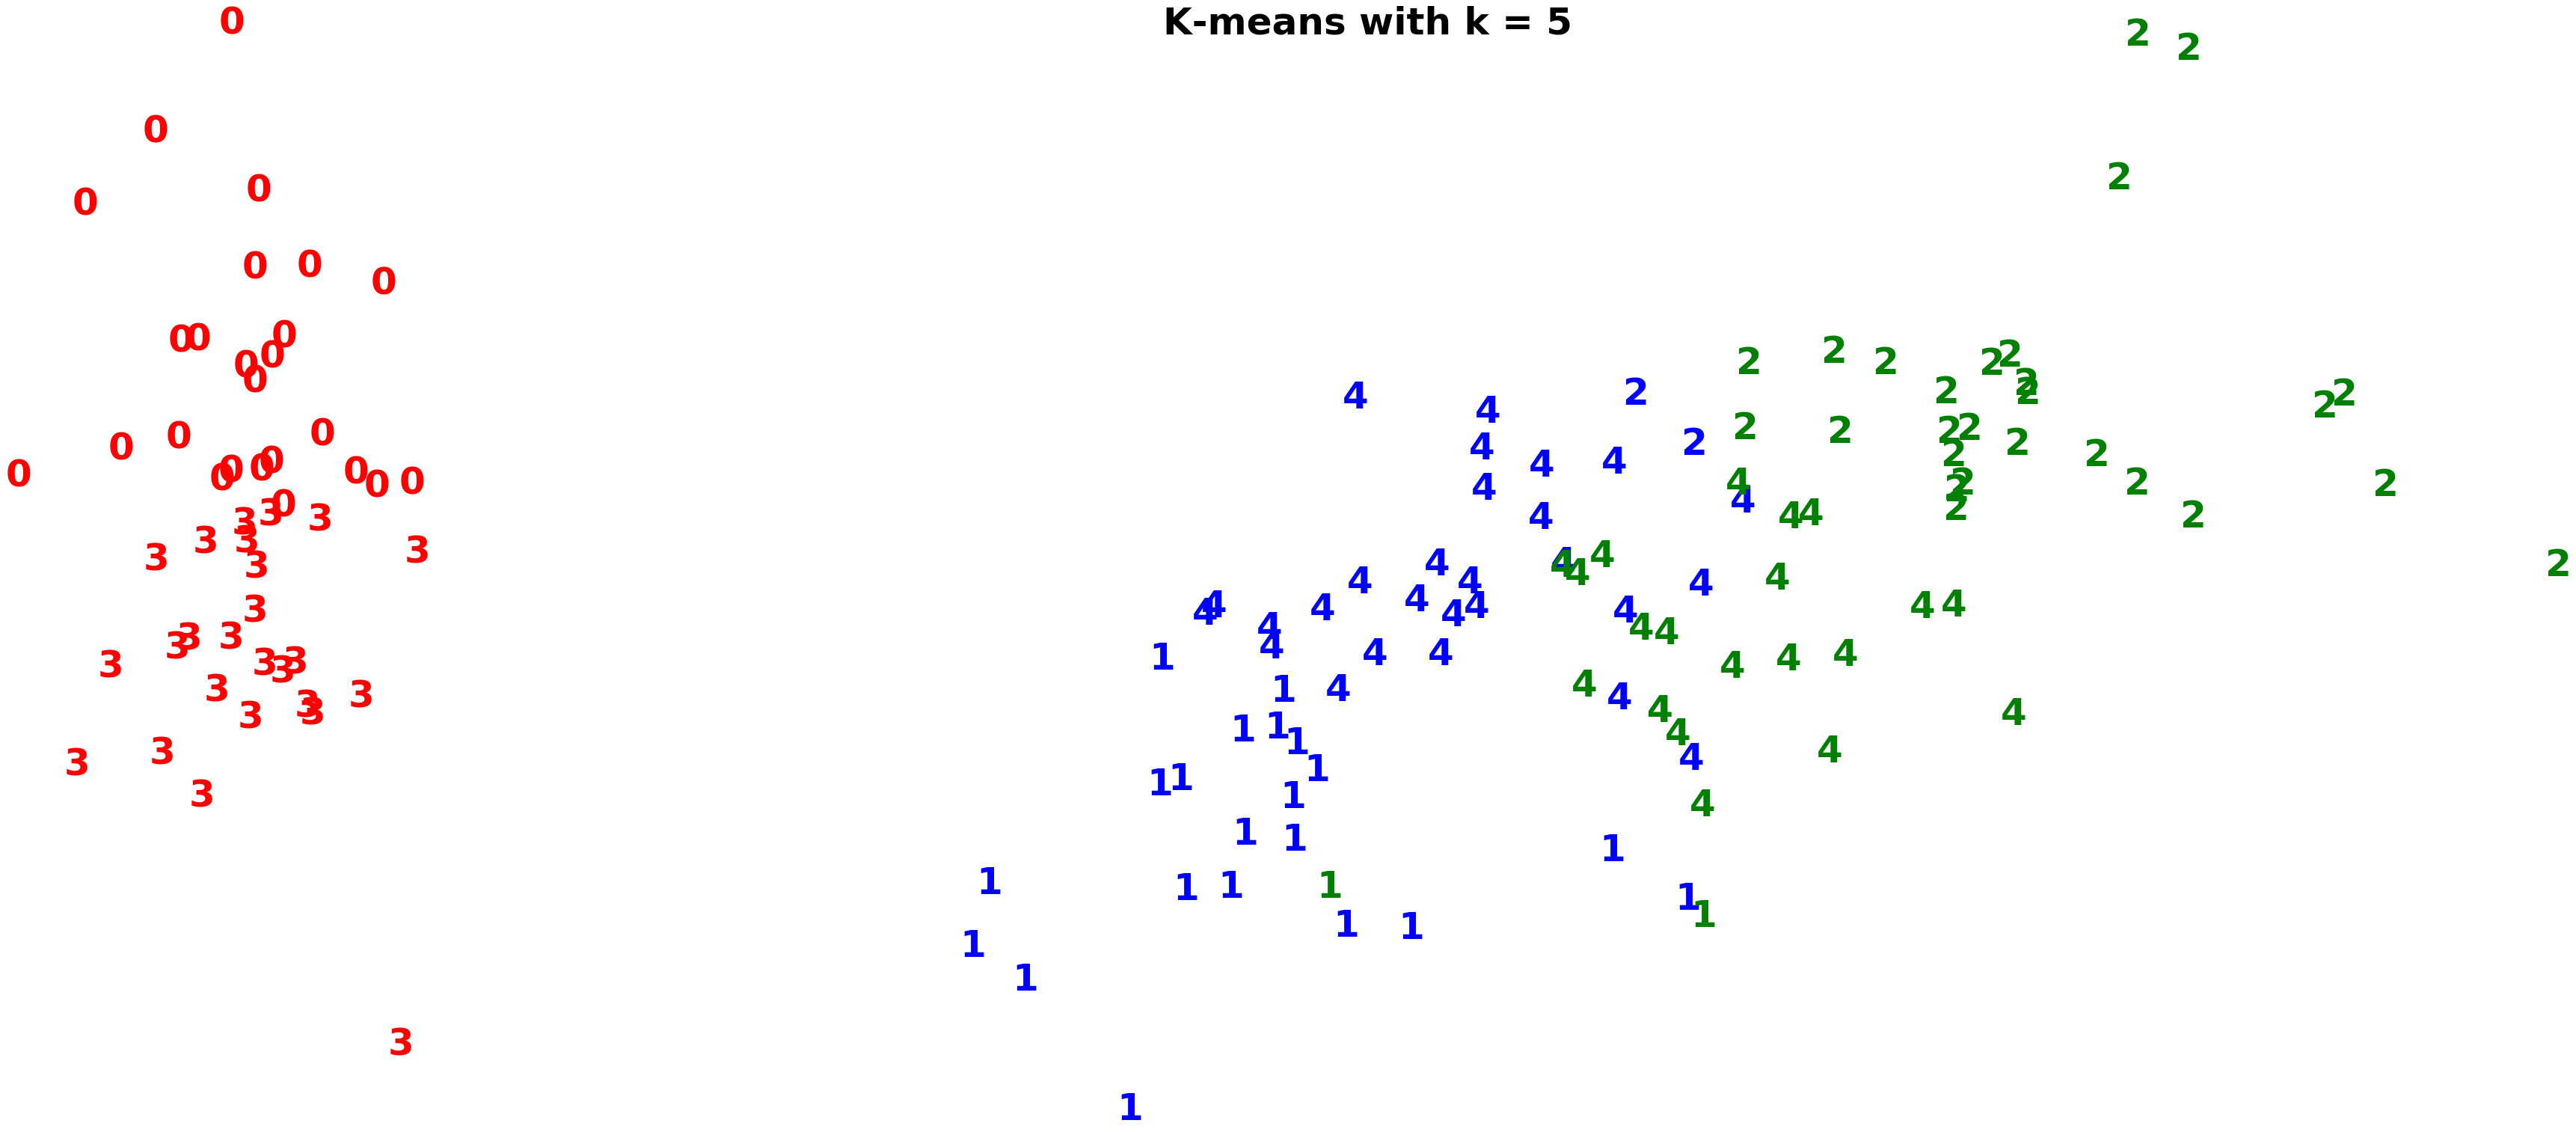

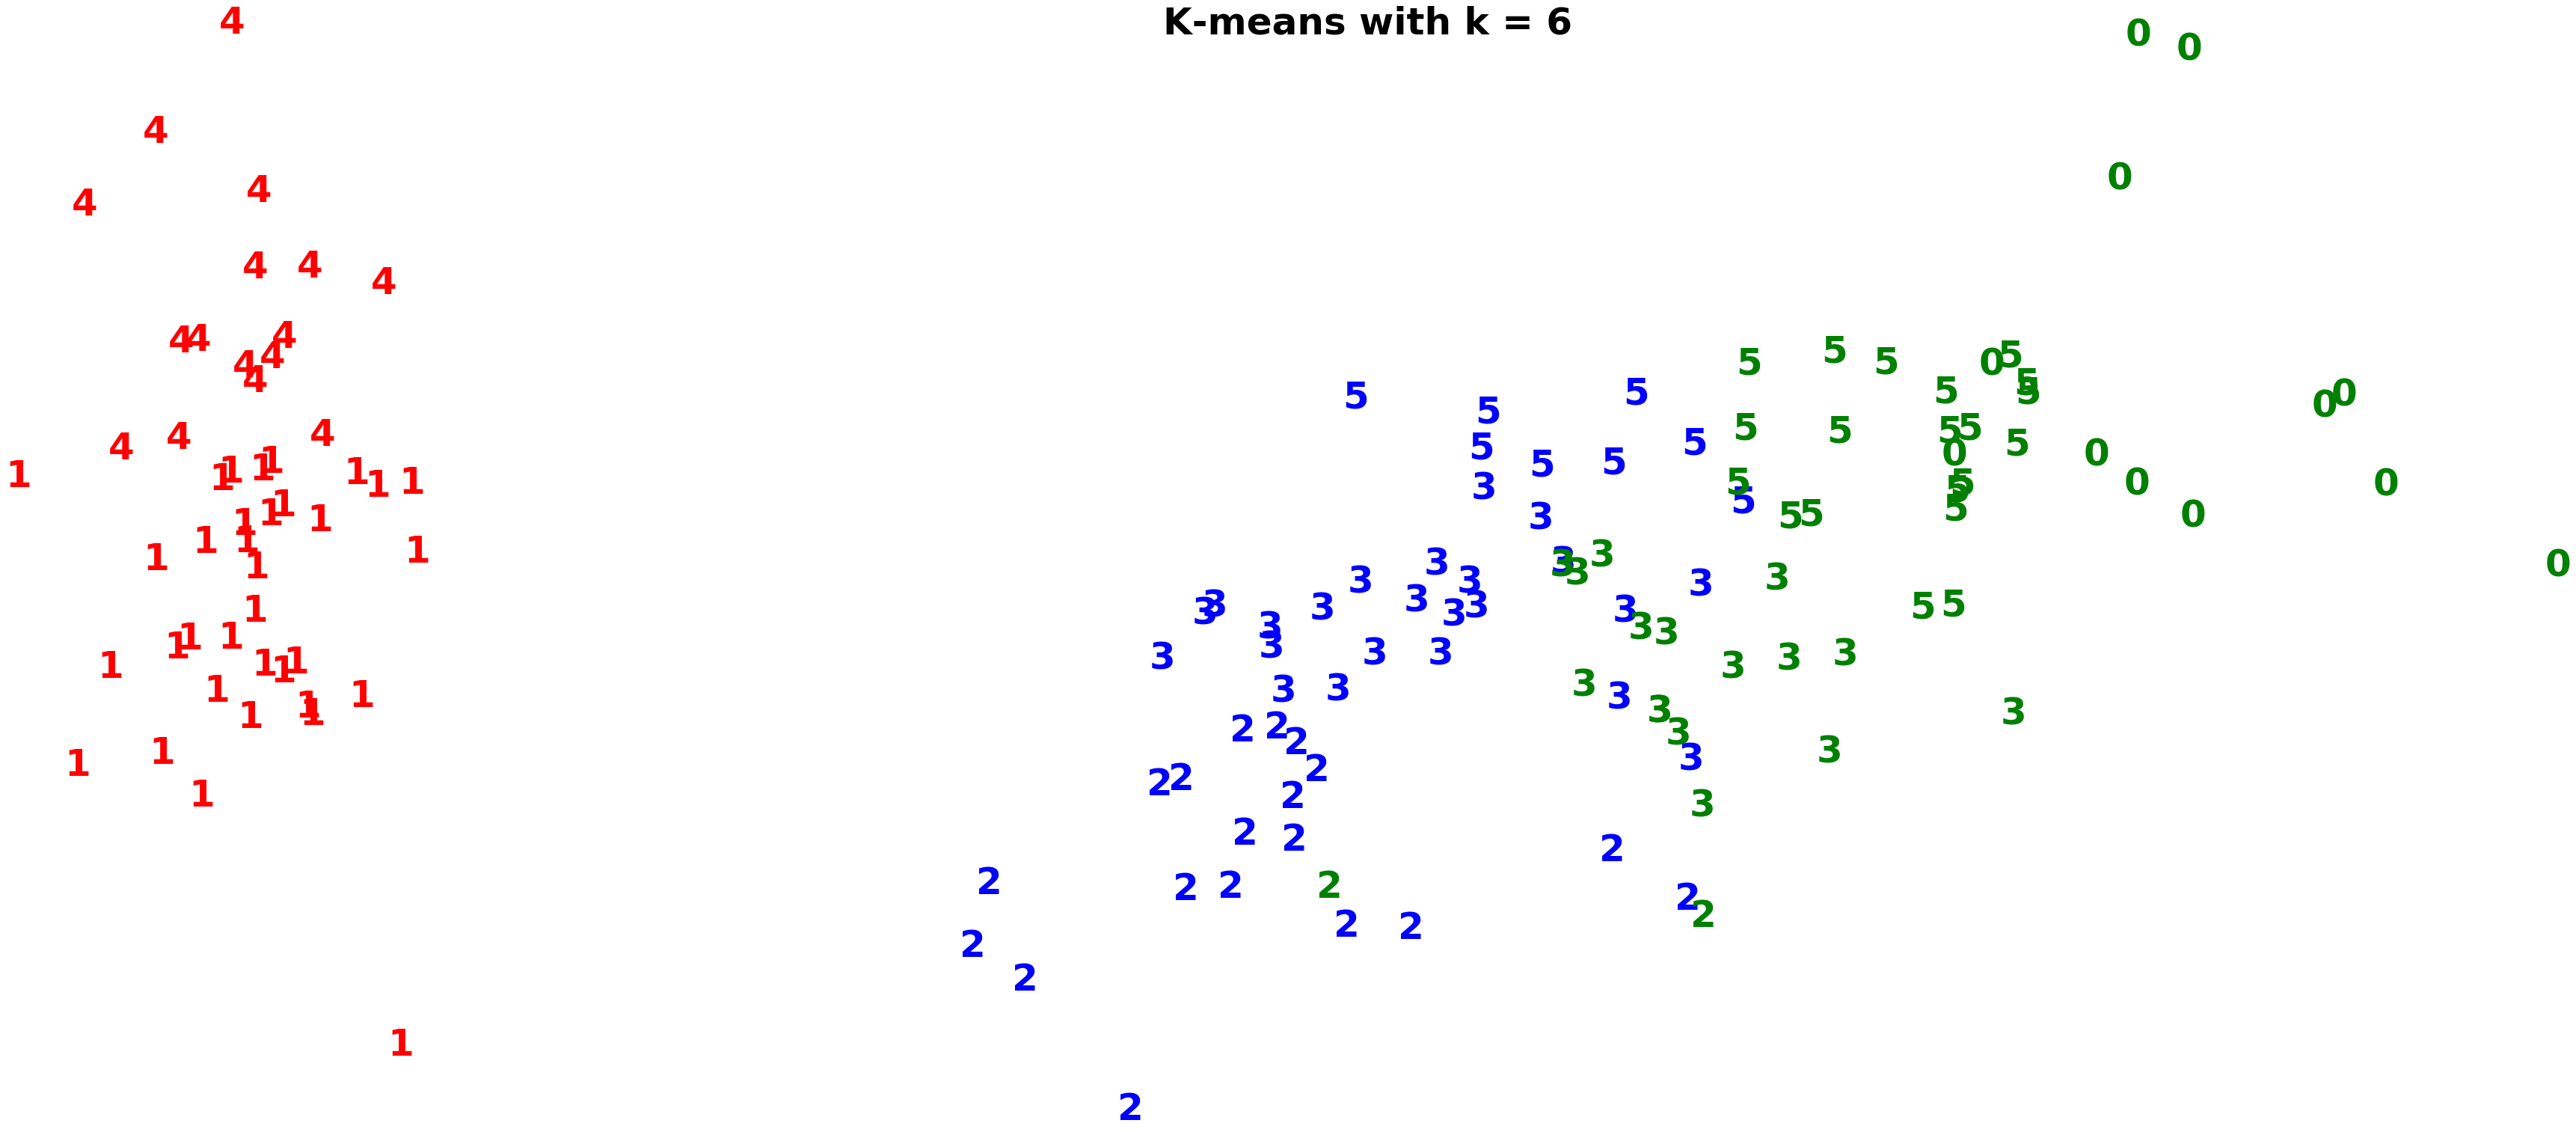

In [4]:
pca = PCA(n_components=2).fit_transform(X_std)

colours = 'rbg'
for i, solution in enumerate(kmeans_clusters):
    plt.figure(figsize=(10,5))
    plt.text(np.mean(pca[:,0]), np.max(pca[:, 1]), "K-means with k = {}".format(cluster_numbers[i]),
                 fontdict={'weight': 'bold', 'size': 50})
    for i in range(pca.shape[0]):
        plt.text(pca[i, 0], pca[i, 1], str(solution[i]),
                 color=colours[y[i]],
                 fontdict={'weight': 'bold', 'size': 50}
            )

    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

Among the solutions, only the ones with k is equal to 2 and 3 assign a single cluster to the linearly separable class at the left most part of the figures. The others assign more than one class which we don't want for sure. So, k = 2 or k=3 is the only viable ones. However, when k=2, k-means can only assign a single cluster to the linearly non-separable classes where k=3 can assign them to two clusters. Hence, as we might expect, the best solution seems the be the one where k is equal to 3.

#### Create a k-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters. Note that in this case, we actually know the correct number of clusters in the data which is two. But, you'll test whether k-means will assign observations as we expect it to do. Since k-means is an unsupervised learning algorithm, it will be blind to whether or not patients have heart disease

First we load the dataset and then normalize our variables. Also, to make it easier to visualize the clusters, we reduce the data to 2 components using PCA

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [8]:
heartdisease_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

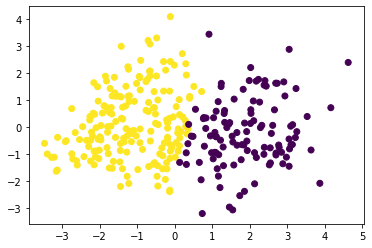

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0      101   13
1       38  151


In [11]:
# Standardize the data.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Reduce it to two components for visualization
X_pca = PCA(2).fit_transform(X_std)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Looks like this model is doing ok. We're correctly classifying 252 cases out of 204.

## Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

In [12]:
# Make sure the number of rows divides evenly into four samples.
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

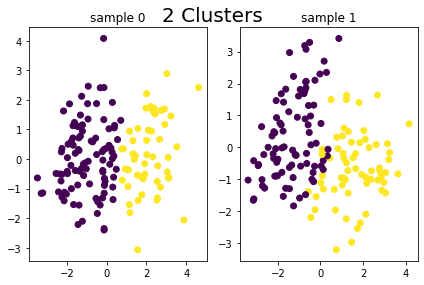

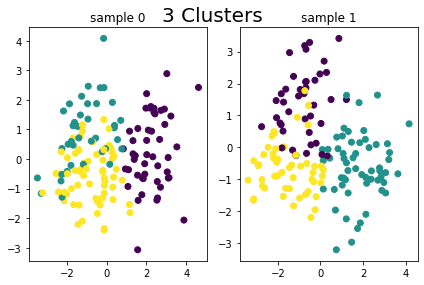

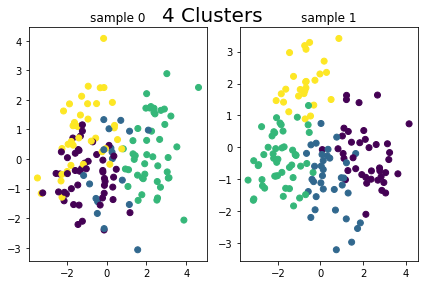

In [13]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

The two cluster solution seems to be the only consistent solution among all.

###  Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

In [14]:

pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for two cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_2)))
print("ARI for three cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_3)))
print("ARI for four cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.280694132678885
ARI for four cluster k-means: 0.19162596502170298


According to the results, the best solution is the two cluster solution as its ARI score is the highest.

## Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [15]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("Silhouette score for two cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_4, metric='euclidean')))

Silhouette score for two cluster k-means: 0.17440650461256255
Silhouette score for three cluster k-means: 0.12862190702187828
Silhouette score for four cluster k-means: 0.1314736248593191


According to the results, the best solution is the two cluster solution as its silhouette score is the highest.

## Produce dendrograms for the heart disease dataset using three different linkage methods: complete, average and ward. Which linkage method do you think produces more reasonable result?

In [16]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Standardize the data.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

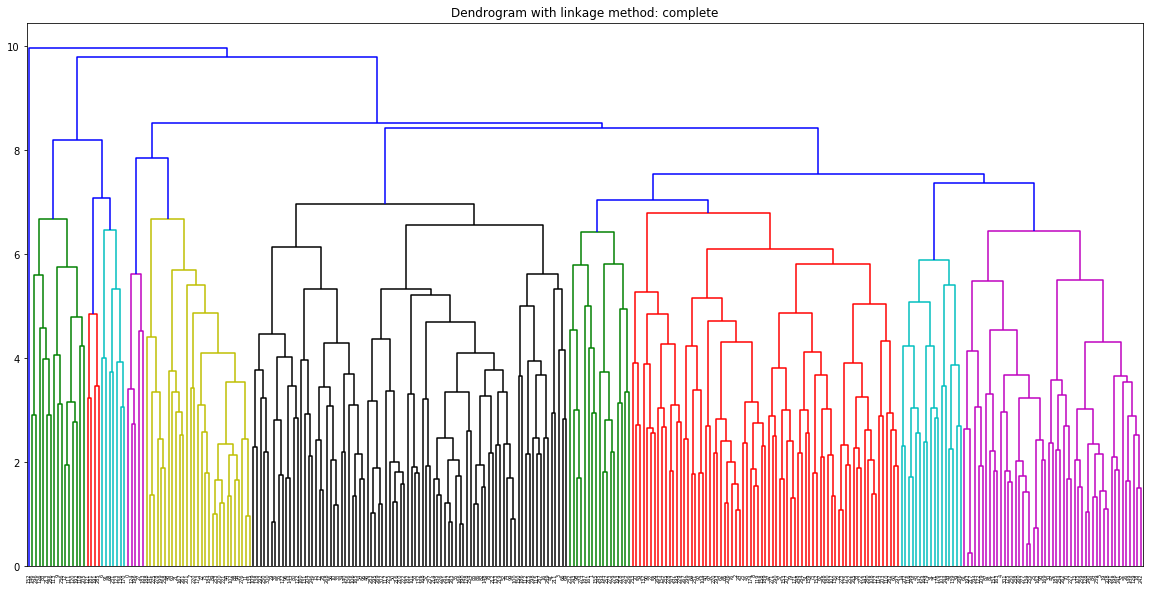

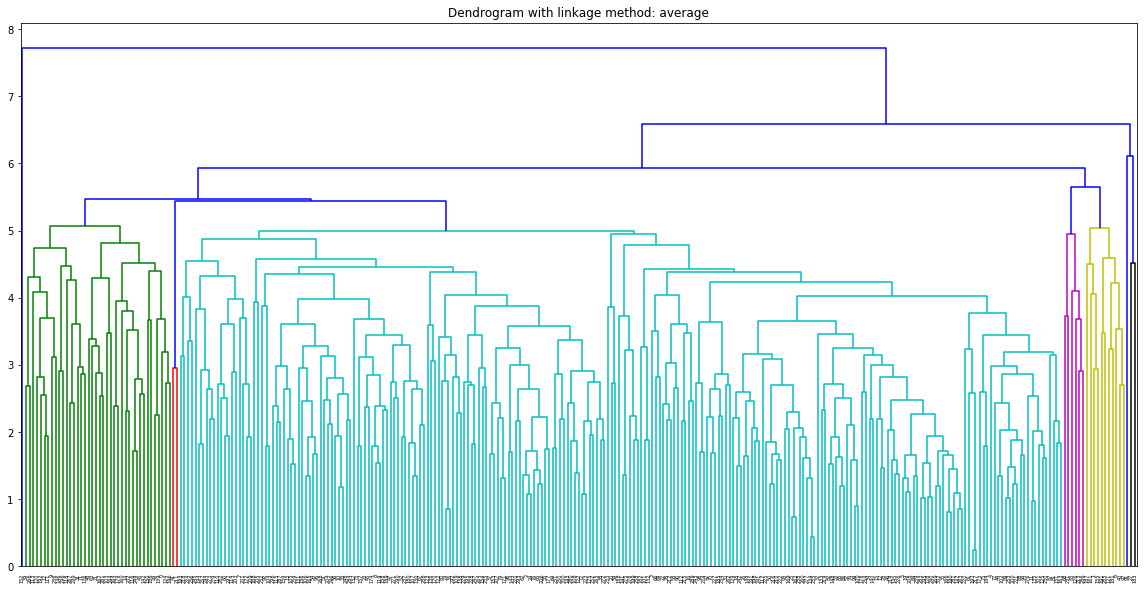

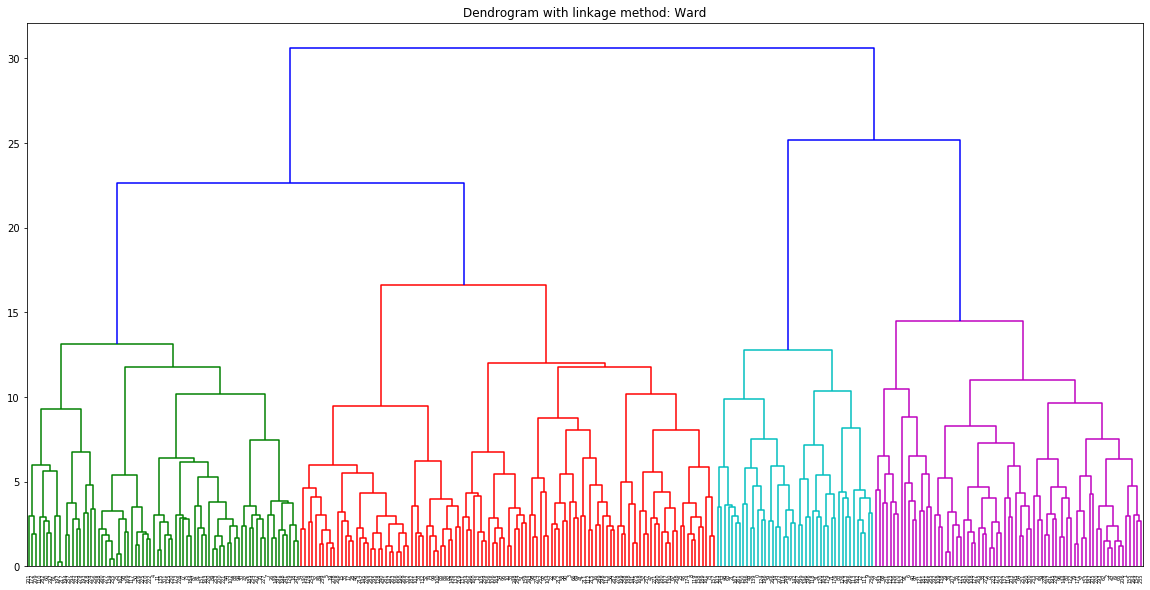

In [17]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

The more reasonable result is that of the ward method's. The complete and average methods produced results that are hard to reconcile with the facts as their two cluster solutions has too few observations for one of the clusters.

## 2. Apply agglomerative clustering to the heart disease data by setting n_clusters=2. Try the three linkage methods above and get ARI and silhouette scores for each of your solutions. Compare the results with each other and with that of the k-means solution that you implemented in the assignment of the previous checkpoint. Which algorithm and setting does perform better?

In [18]:
linkage_methods = ["ward", "average", "complete"]

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="average", 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

print("ARI score of linkage method average: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score of linkage method average: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------")

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="complete", 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

print("ARI score of linkage method complete: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score of linkage method complete: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------")

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

print("ARI score of linkage method ward: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score of linkage method ward: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

ARI score of linkage method average: 0.2940490133353465
Silhouette score of linkage method average: 0.14837359969689895
------------------------------------------------
ARI score of linkage method complete: 0.21394030618551016
Silhouette score of linkage method complete: 0.11730765444448985
------------------------------------------------
ARI score of linkage method ward: 0.146129913123814
Silhouette score of linkage method ward: 0.1387197366557222


According to the results, the best scores are achieved by the linkage methode average. The ARI and silhouette scores of the two cluster k-means solution was 0.44 and 0.17 respectively. So, in terms of ARI the best model seems to be k-means, however in terms of silhouette score the best one is agglomerative clustering.

## Apply DBSCAN to the heart disease data by trying different values for eps and min_samples parameters. You'll realize that it's really hard to get a two cluster solution using DBSCAN if not impossible.

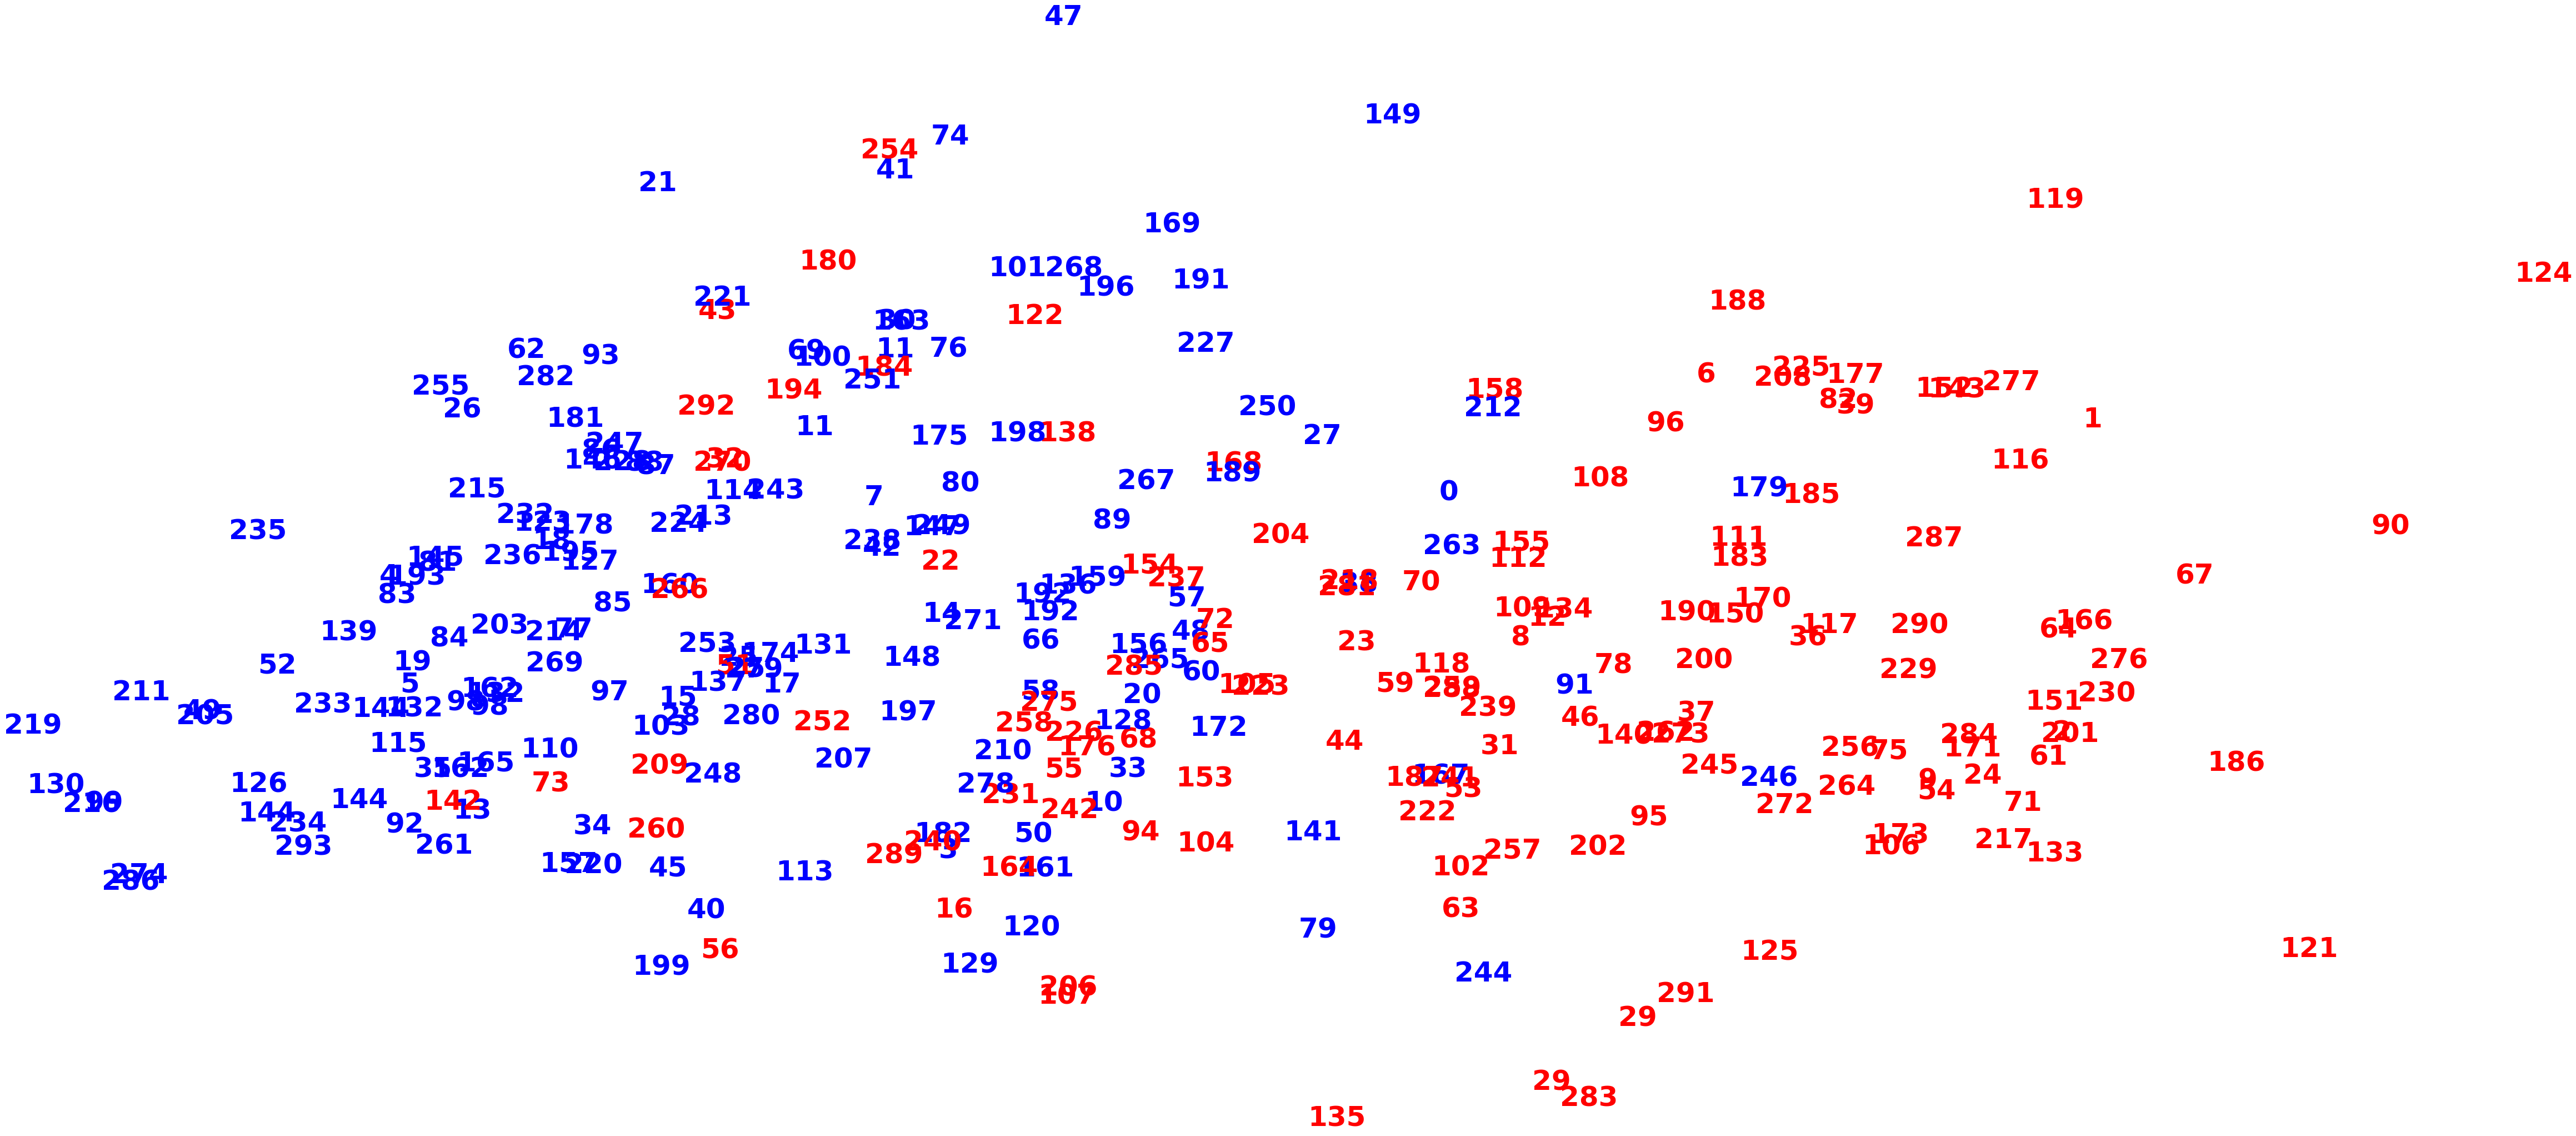

In [19]:
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbgrg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of min_samples. What's the effect of increasing min_samples on the number of clusters DBSCAN identifies?

In [20]:
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when min_samples=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,51)

for i in range(2,51):
    dbscan_cluster = DBSCAN(eps=1, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when min_samples=1 is: 294
Number of clusters when min_samples=2 is: 9
Number of clusters when min_samples=3 is: 2
Number of clusters when min_samples=4 is: 1
Number of clusters when min_samples=5 is: 1
Number of clusters when min_samples=6 is: 1
Number of clusters when min_samples=7 is: 1
Number of clusters when min_samples=8 is: 1
Number of clusters when min_samples=9 is: 1
Number of clusters when min_samples=10 is: 1
Number of clusters when min_samples=11 is: 1
Number of clusters when min_samples=12 is: 1
Number of clusters when min_samples=13 is: 1
Number of clusters when min_samples=14 is: 1
Number of clusters when min_samples=15 is: 1
Number of clusters when min_samples=16 is: 1
Number of clusters when min_samples=17 is: 1
Number of clusters when min_samples=18 is: 1
Number of clusters when min_samples=19 is: 1
Number of clusters when min_samples=20 is: 1
Number of clusters when min_samples=21 is: 1
Number of clusters when min_samples=22 is: 1
Number of cluster

Number of clusters seems to decrease with as epsilon increases.

## Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of eps. What's the effect of increasing eps on the number of clusters DBSCAN identifies?

In [21]:
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when eps=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,51)

for i in [0.01,0.1,1,2,3,4,5,6,7,8,9,10]:
    dbscan_cluster = DBSCAN(eps=i, min_samples=1, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when eps={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when eps=1 is: 294
Number of clusters when eps=0.01 is: 303
Number of clusters when eps=0.1 is: 303
Number of clusters when eps=1 is: 294
Number of clusters when eps=2 is: 178
Number of clusters when eps=3 is: 34
Number of clusters when eps=4 is: 3
Number of clusters when eps=5 is: 1
Number of clusters when eps=6 is: 1
Number of clusters when eps=7 is: 1
Number of clusters when eps=8 is: 1
Number of clusters when eps=9 is: 1
Number of clusters when eps=10 is: 1


Number of clusters seems to decrease with as min_samples increases.

## Apply GMM to the heart disease data by setting n_components=2. Get ARI and silhoutte scores for your solution and compare it with those of the k-means and hierarchical clustering solutions that you implemented in the assignments of the previous checkpoints. Which algorithm does perform better

In [26]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

ARI score: 0.18389186035089963
Silhouette score: 0.13628813153331445


GMM scores lower than both k-means and hierarchical clustering in terms of ARI and silhouette scores.

## GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. Specifically, there are four types you can specify:

* full: This is the default. Each component has its own general covariance matrix.
* tied: All components share the same general covariance matrix.
* diag: Each component has its own diagonal covariance matrix.
* spherical: Each component has its own single variance.

Try all of these. Which one does perform better in terms of ARI and silhouette scores?

In [28]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="full")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=full: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=full: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="tied")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=tied: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=tied: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="diag")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=diag: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=diag: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")


# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="spherical")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=spherical: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=spherical: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

ARI score with covariance_type=full: 0.18389186035089963
Silhouette score with covariance_type=full: 0.13628813153331445
------------------------------------------------------
ARI score with covariance_type=tied: 0.18389186035089963
Silhouette score with covariance_type=tied: 0.13628813153331445
------------------------------------------------------
ARI score with covariance_type=diag: 0.18389186035089963
Silhouette score with covariance_type=diag: 0.13628813153331445
------------------------------------------------------
ARI score with covariance_type=spherical: 0.20765243525722465
Silhouette score with covariance_type=spherical: 0.12468753110276873
------------------------------------------------------


ARI score of covariance type spherical is higher than the others and its silhouette score is lower than the others. The scores of the other covariance types are the same.